<a href="https://colab.research.google.com/github/himanshunaidu/human_or_horse/blob/master/HumanHorse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import os
import random
import math
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

In [17]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


#Loading Dataset

In [2]:
#TRAINING SET
!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
-O /tmp/horse-or-human.zip

--2021-08-26 16:24:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   294MB/s    in 0.5s    

2021-08-26 16:24:32 (294 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [3]:
dataset_zip_path = '/tmp/horse-or-human.zip'
dataset_ref = zipfile.ZipFile(dataset_zip_path)
dataset_ref.extractall('/tmp/horse-or-human')
dataset_ref.close()

In [4]:
train_human_dir = '/tmp/horse-or-human/humans'
train_horse_dir = '/tmp/horse-or-human/horses'

In [5]:
train_human_names = os.listdir(train_human_dir)
print(len(train_human_names))
train_horse_names = os.listdir(train_horse_dir)
print(len(train_horse_names))

527
500


In [ ]:
#Experiment to find the dimensions
min_height, min_width = math.inf, math.inf
max_height, max_width = -1, -1
avg_height, avg_width = 0, 0

for i, path in enumerate(validation_human_names):
  image_path = os.path.join(validation_human_dir, path)
  img = Image.open(image_path)
  width, height = img.size

  min_height, min_width = min(min_height, height), min(min_width, width)
  max_height, max_width = max(min_height, height), max(min_width, width)
  avg_height, avg_width = avg_height+height, avg_width+width

avg_height, avg_width = avg_height//len(validation_human_names), avg_width//len(validation_human_names)
print(min_height, min_width)
print(max_height, max_width)
print(avg_height, avg_width)

In [7]:
#VALIDATION SET
!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
-O /tmp/validation-horse-or-human.zip

--2021-08-26 16:25:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/validation-horse-or-human.zip’

/tmp/validation-hor 100%[===================>]  10.95M  58.1MB/s    in 0.2s    

2021-08-26 16:25:21 (58.1 MB/s) - ‘/tmp/validation-horse-or-human.zip’ saved [11480187/11480187]



In [8]:
dataset_validation_zip_path = '/tmp/validation-horse-or-human.zip'
dataset_validation_ref = zipfile.ZipFile(dataset_zip_path)
dataset_validation_ref.extractall('/tmp/validation-horse-or-human')
dataset_validation_ref.close()

In [9]:
validation_human_dir = '/tmp/validation-horse-or-human/humans'
validation_horse_dir = '/tmp/validation-horse-or-human/horses'

In [10]:
validation_human_names = os.listdir(validation_human_dir)
print(len(validation_human_names))
validation_horse_names = os.listdir(validation_horse_dir)
print(len(validation_horse_names))

527
500


#Data Pre-processing

In [11]:
train_datagen = image.ImageDataGenerator(rescale=1/255.0)
train_generator = train_datagen.flow_from_directory('/tmp/horse-or-human', target_size=(300, 300), color_mode='rgb',\
                                                    class_mode='binary', batch_size=128)

Found 1027 images belonging to 2 classes.


In [23]:
validation_datagen = image.ImageDataGenerator(rescale=1/255.0)
validation_generator = train_datagen.flow_from_directory('/tmp/validation-horse-or-human', target_size=(300, 300), \
                                                       color_mode='rgb', class_mode='binary', batch_size=128)

Found 1027 images belonging to 2 classes.


#Create Model

In [13]:
#params
alpha = 0.15
dropout_rate = 0.3

In [60]:
#Model
i = Input(shape=(300, 300, 3))

#Convolution 1
x = Conv2D(8, (3, 3), strides=(1, 1), padding='valid', activation=LeakyReLU(alpha=alpha))(i)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2), strides=(2, 2))(x)

#Convolution 2
x = Conv2D(16, (3, 3), strides=(1, 1), padding='valid', activation=LeakyReLU(alpha=alpha))(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2), strides=(2, 2))(x)

#Convolution 3
x = Conv2D(32, (3, 3), strides=(1, 1), padding='valid', activation=LeakyReLU(alpha=alpha))(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2), strides=(2, 2))(x)

x = Flatten()(x)

x = Dense(100, activation=LeakyReLU(alpha=alpha))(x)
x = Dropout(rate=dropout_rate)(x)
# x = Dense(100, activation=LeakyReLU(alpha=alpha))(x)
# x = Dropout(rate=dropout_rate)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [61]:
print(model.summary())

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 298, 298, 8)       224       
_________________________________________________________________
batch_normalization_11 (Batc (None, 298, 298, 8)       32        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 149, 149, 8)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 147, 147, 16)      1168      
_________________________________________________________________
batch_normalization_12 (Batc (None, 147, 147, 16)      64        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 73, 73, 16)        0  

In [62]:
#Compile
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#TRAINING

In [63]:
save_path = "gdrive/My Drive/Colab Notebooks/HH1/HH1"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True, verbose=1)

In [64]:
history = model.fit(train_generator, steps_per_epoch=8, epochs=15, validation_data=validation_generator, \
                    callbacks=[])

Epoch 1/15
8/8 [==============================] - 15s 2s/step - loss: 3.1960 - accuracy: 0.7731 - val_loss: 2.7665 - val_accuracy: 0.5297
Epoch 2/15
8/8 [==============================] - 12s 2s/step - loss: 0.5603 - accuracy: 0.9544 - val_loss: 2.4809 - val_accuracy: 0.5385
Epoch 3/15
8/8 [==============================] - 12s 2s/step - loss: 0.1720 - accuracy: 0.9644 - val_loss: 3.3556 - val_accuracy: 0.5093
Epoch 4/15
8/8 [==============================] - 12s 2s/step - loss: 0.0752 - accuracy: 0.9844 - val_loss: 3.7203 - val_accuracy: 0.6485
Epoch 5/15
8/8 [==============================] - 12s 2s/step - loss: 0.0591 - accuracy: 0.9844 - val_loss: 4.7123 - val_accuracy: 0.6884
Epoch 6/15
8/8 [==============================] - 12s 2s/step - loss: 0.0338 - accuracy: 0.9944 - val_loss: 5.6625 - val_accuracy: 0.6923
Epoch 7/15
8/8 [==============================] - 12s 2s/step - loss: 0.0130 - accuracy: 0.9978 - val_loss: 8.0773 - val_accuracy: 0.6115
Epoch 8/15
8/8 [==================

# VISUALIZE FILTERS

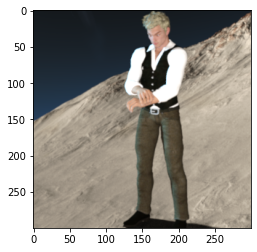

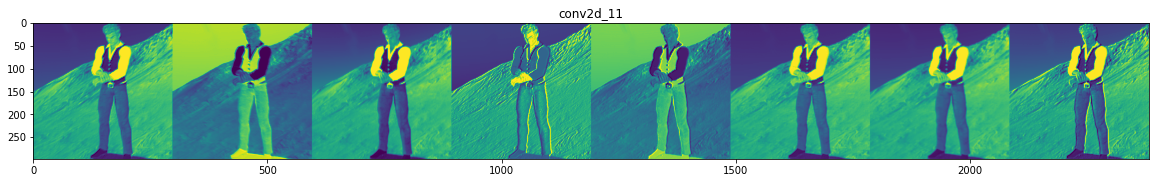

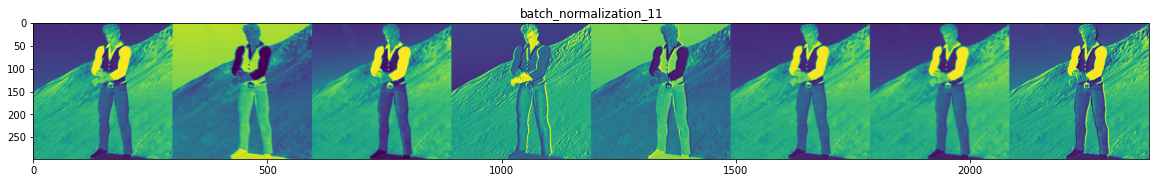

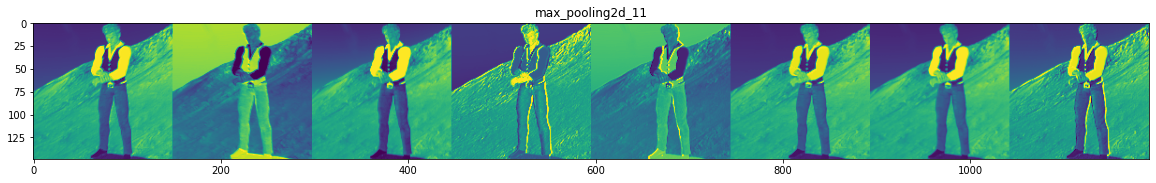

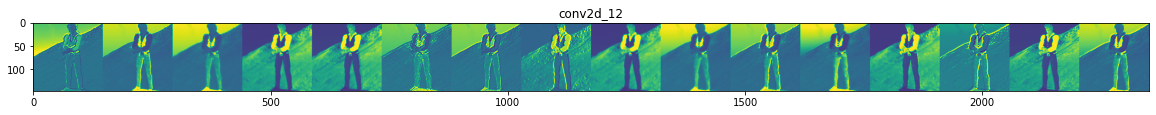

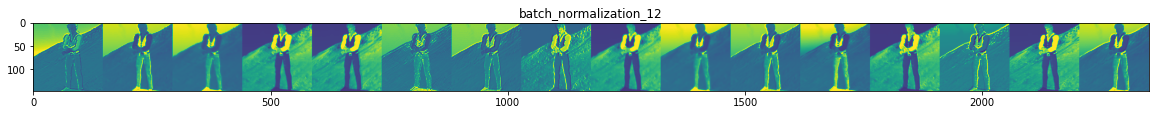

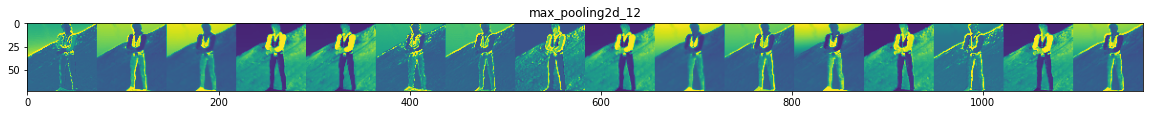

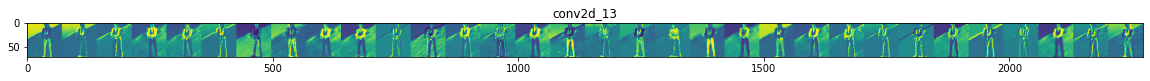

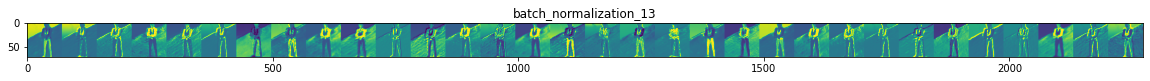

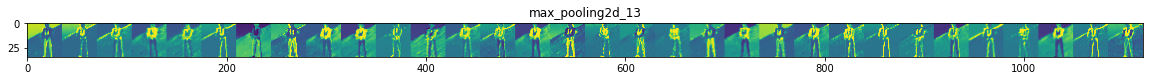

In [65]:
#Aim is to visualize all intermediate filters of the model
#For that, we create a separate visualization model
all_outputs = [layer.output for layer in model.layers[1:]]
layer_names = [layer.name for layer in model.layers[1:]]
visualization_model = Model(inputs = model.input, outputs = all_outputs)

#Pick a random image
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

#Pre-process for the model
img = image.load_img(img_path, color_mode='rgb', target_size=(300, 300))
img = image.img_to_array(img)
img = img/255.0
plt.imshow(img)
img = img.reshape((1,)+img.shape)

# Get image representations through visualization model
successive_feature_maps = visualization_model.predict(img)

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  #Visualization is only for Convolutional layers
  if len(feature_map.shape)==4:
    n_features = feature_map.shape[-1]  # number of features in feature map
    size = feature_map.shape[1]
    # print(feature_map.shape)

    # Tile the maps in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      #Post-processing
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')